### **LIBRARY**

In [ ]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow_hub as hub

### **IMPORT DATA**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Getting names of the classes we have
data_directory = pathlib.Path('/content/drive/MyDrive/DEEP LEARNING/test')
class_names = [item.name for item in data_directory.glob('*')][:2]
print(class_names)

['not_pizza', 'pizza']


In [ ]:
pizza_dir = '/content/drive/MyDrive/DEEP LEARNING/train/pizza'
not_pizza_dir = '/content/drive/MyDrive/DEEP LEARNING/train/not_pizza'
data_dir = '/content/drive/MyDrive/DEEP LEARNING/train'

In [ ]:
pizza_dir

'/content/drive/MyDrive/DEEP LEARNING/train/pizza'

In [ ]:
num_pizza_images = len(os.listdir(pizza_dir))
non_pizza_images = len(os.listdir(not_pizza_dir))
print(f'Number of Pizza images: {num_pizza_images}')
print(f'Number of Non-Pizza images: {non_pizza_images}')

Number of Pizza images: 800
Number of Non-Pizza images: 800


### **VISUALISASI IMAGE**

In [ ]:
# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(data_dir,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(data_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 1280 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [ ]:
# Mengambil satu batch data pelatihan dari generator data
images, labels = train_data.next()
len(images), len(labels), images[0].shape

(32, 32, (224, 224, 3))

In [ ]:
def plot_random_images():
    """
    Plots 20 Random Images from the dataset
    """

    images, labels = train_data.next()
    labels = labels.astype('int32')
    i = 1

    plt.figure(figsize = (10, 5))

    for image, label in zip(images, labels):
        plt.subplot(4, 5, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == 21:
            break

    plt.tight_layout()
    plt.show()

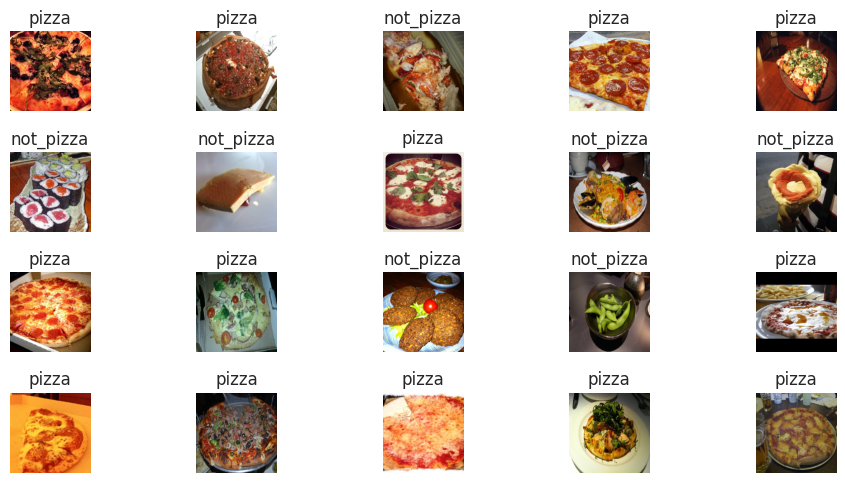

In [ ]:
plot_random_images()

# **BASELINE MODEL**

Pertama, dibuat baseline model tanpa menggunakan data augmentasi dan tidak menambahkan max pooling layer

In [ ]:
tf.random.set_seed(42)
model_1 = Sequential([
    Input(shape = (224, 224, 3)), # Input layer
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # First Convolutional layer
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'), # Second Convolutional layer
    Flatten(),
    Dense(1, activation = 'sigmoid') # Output layer
])

model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_1 = model_1.fit(train_data,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/5
40/40 [==============================] - 223s 5s/step - loss: 4.6858 - accuracy: 0.5086 - val_loss: 0.6656 - val_accuracy: 0.5844
Epoch 2/5
40/40 [==============================] - 6s 159ms/step - loss: 0.6119 - accuracy: 0.6844 - val_loss: 0.6752 - val_accuracy: 0.6656
Epoch 3/5
40/40 [==============================] - 8s 212ms/step - loss: 0.4029 - accuracy: 0.8367 - val_loss: 0.6142 - val_accuracy: 0.6719
Epoch 4/5
40/40 [==============================] - 6s 157ms/step - loss: 0.1657 - accuracy: 0.9578 - val_loss: 0.6247 - val_accuracy: 0.7219
Epoch 5/5
40/40 [==============================] - 7s 170ms/step - loss: 0.0585 - accuracy: 0.9930 - val_loss: 0.7612 - val_accuracy: 0.7031


In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Plots the curves of both loss and accuracy
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    fig, ax = plt.subplots(1, 2, figsize = (20, 5))

    # Plotting loss
    ax1 = sns.lineplot(x = epochs, y = loss, label='Training Loss', ax= ax[0])
    ax1 = sns.lineplot(x = epochs, y = val_loss, label='Validation Loss', ax= ax[0])
    ax1.set(title = 'Loss', xlabel = 'Epochs')

    # Plot accuracy
    ax2 = sns.lineplot(x = epochs, y = accuracy, label='Training Accuracy', ax= ax[1])
    ax2 = sns.lineplot(x = epochs, y = val_accuracy, label='Validation Accuracy', ax=ax[1])
    ax2.set(title = 'Accuracy', xlabel = 'Epochs')

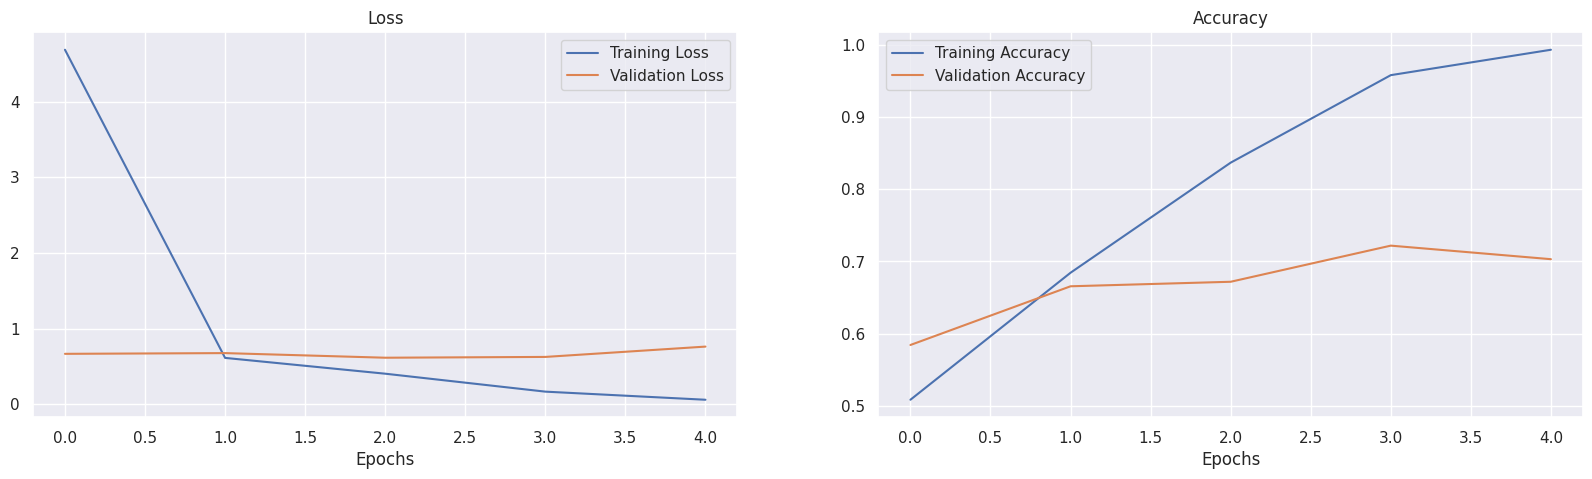

In [ ]:
plot_loss_curves(history_1)

### **MAX POOLING LAYER**

Dilakukan penambahan max pooling layer

In [ ]:
model_2 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_2.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/5
40/40 [==============================] - 9s 190ms/step - loss: 0.8268 - accuracy: 0.5297 - val_loss: 0.6362 - val_accuracy: 0.7188
Epoch 2/5
40/40 [==============================] - 6s 160ms/step - loss: 0.5952 - accuracy: 0.6875 - val_loss: 0.5831 - val_accuracy: 0.7125
Epoch 3/5
40/40 [==============================] - 7s 170ms/step - loss: 0.5089 - accuracy: 0.7492 - val_loss: 0.5424 - val_accuracy: 0.7281
Epoch 4/5
40/40 [==============================] - 8s 191ms/step - loss: 0.4481 - accuracy: 0.7992 - val_loss: 0.6628 - val_accuracy: 0.6875
Epoch 5/5
40/40 [==============================] - 7s 170ms/step - loss: 0.3235 - accuracy: 0.8828 - val_loss: 0.5751 - val_accuracy: 0.7312


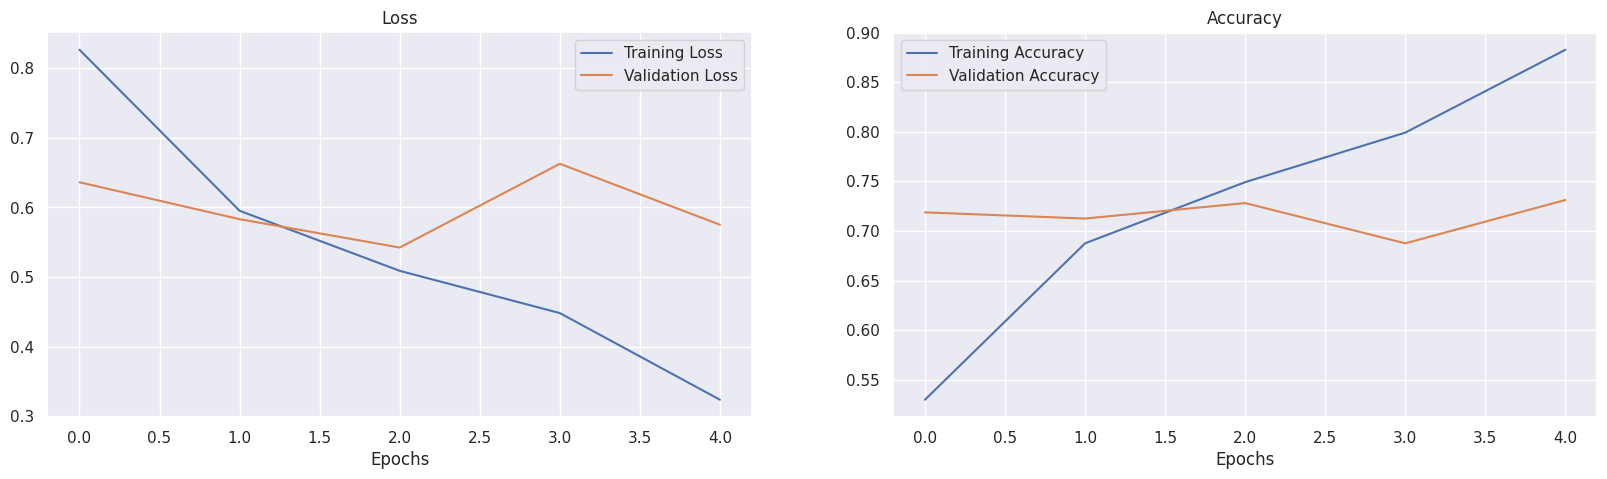

In [ ]:
plot_loss_curves(history_2)

### **DATA AUGMENTATION**

In [ ]:
data_gen_augmented = ImageDataGenerator(rescale = 1/255.,
                                        validation_split = 0.2,
                                        zoom_range = 0.2,
                                        horizontal_flip= True,
                                        rotation_range = 20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2)

print('Augmented training Images:')
train_data_augmented = data_gen_augmented.flow_from_directory(data_dir,
                                                              target_size = (224, 224),
                                                              batch_size = 32,
                                                              subset = 'training',
                                                              class_mode = 'binary')
print('Unchanged Validation Images:')
val_data = data_gen.flow_from_directory(data_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Augmented training Images:
Found 1280 images belonging to 2 classes.
Unchanged Validation Images:
Found 320 images belonging to 2 classes.


In [ ]:
model_3 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_3.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_3 = model_3.fit(train_data_augmented,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/5
40/40 [==============================] - 23s 541ms/step - loss: 0.7406 - accuracy: 0.5773 - val_loss: 0.5979 - val_accuracy: 0.7031
Epoch 2/5
40/40 [==============================] - 21s 533ms/step - loss: 0.6013 - accuracy: 0.6727 - val_loss: 0.5857 - val_accuracy: 0.7000
Epoch 3/5
40/40 [==============================] - 24s 594ms/step - loss: 0.6033 - accuracy: 0.6656 - val_loss: 0.5535 - val_accuracy: 0.7656
Epoch 4/5
40/40 [==============================] - 21s 522ms/step - loss: 0.5821 - accuracy: 0.7070 - val_loss: 0.5792 - val_accuracy: 0.7125
Epoch 5/5
40/40 [==============================] - 23s 566ms/step - loss: 0.5856 - accuracy: 0.6938 - val_loss: 0.5573 - val_accuracy: 0.7469


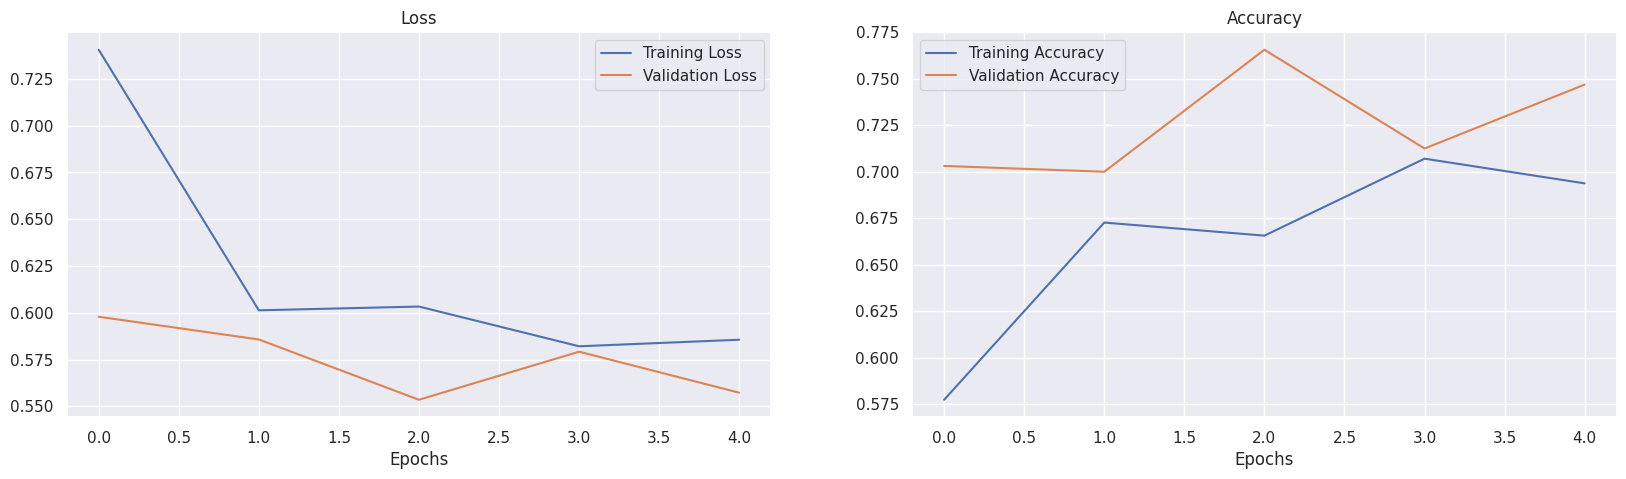

In [ ]:
plot_loss_curves(history_3)

### **IMPROVING MODEL**

Beberapa hal yang dilakukan dalam improving model adalah:
1. Menambahkan epochs
2. Mengubah angka filter
3. Penambahan convolutional layers

In [ ]:
model_4 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 10, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'), MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_4.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])

history_4 = model_4.fit(train_data_augmented,
                        epochs= 10,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/10
40/40 [==============================] - 23s 508ms/step - loss: 0.6823 - accuracy: 0.5516 - val_loss: 0.6545 - val_accuracy: 0.6438
Epoch 2/10
40/40 [==============================] - 22s 533ms/step - loss: 0.6458 - accuracy: 0.6492 - val_loss: 0.6276 - val_accuracy: 0.6719
Epoch 3/10
40/40 [==============================] - 21s 522ms/step - loss: 0.6230 - accuracy: 0.6555 - val_loss: 0.6022 - val_accuracy: 0.6906
Epoch 4/10
40/40 [==============================] - 21s 523ms/step - loss: 0.6052 - accuracy: 0.6687 - val_loss: 0.6211 - val_accuracy: 0.6781
Epoch 5/10
40/40 [==============================] - 25s 611ms/step - loss: 0.6016 - accuracy: 0.6687 - val_loss: 0.5831 - val_accuracy: 0.7063
Epoch 6/10
40/40 [==============================] - 23s 573ms/step - loss: 0.5856 - accuracy: 0.6961 - val_loss: 0.5649 - val_accuracy: 0.7031
Epoch 7/10
40/40 [==============================] - 21s 516ms/step - loss: 0.5761 - accuracy: 0.7203 - val_loss: 0.5644 - val_accuracy: 0.7281

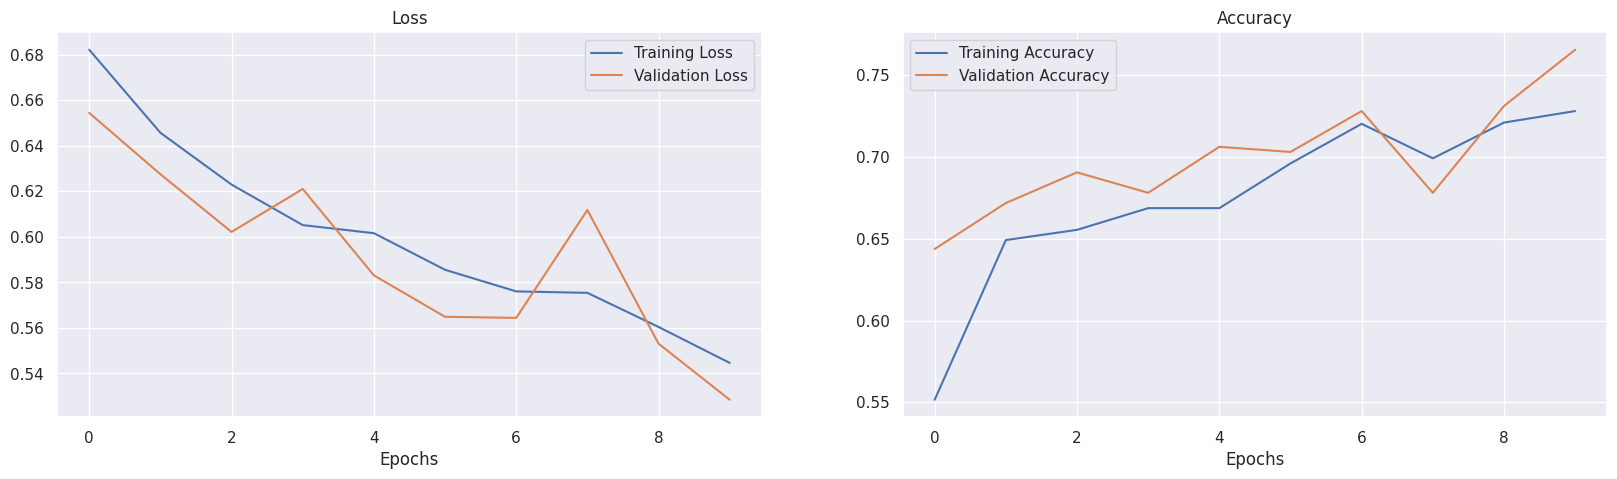

In [ ]:
plot_loss_curves(history_4)

### **TRANSFER LEARNING**

In [ ]:
# EfficientNetB7 feature vector
url = 'https://tfhub.dev/google/efficientnet/b7/feature-vector/1'

feature_extractor_layer = hub.KerasLayer(url,
                                         trainable=False,
                                         input_shape=(224, 224, 3))

model_5 = Sequential([
    feature_extractor_layer,
    Dense(1, activation = 'sigmoid')
])

model_5.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_5 = model_5.fit(train_data,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

40/40 [==============================] - 32s 470ms/step - loss: 0.3075 - accuracy: 0.8922 - val_loss: 0.1549 - val_accuracy: 0.9625


In [ ]:
test_loss, test_acc = model_5.evaluate(val_data)

print(f"test accuracy : {round(test_acc * 100)}%")

10/10 [==============================] - 3s 325ms/step - loss: 0.1549 - accuracy: 0.9625
test accuracy : 96%
